In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample
#import scipy.stats as stats
import random
import re
import statistics
from scipy.stats import wilcoxon
from sklearn.metrics import roc_curve, auc

In [2]:
plt.style.use('ggplot')

In [3]:
def wilcoxon_test(intra, inter):
    w, p = wilcoxon(np.array(intra)-np.array(inter), alternative='greater')
    if (p < 0.05) & (len(intra) > 9):
        return {'test':True, 'pvalue':p}
    else:
        return {'test':False, 'pvalue':p}

def add_number_of_observations(intra_lst, inter_lst):
    for box, lst in enumerate([intra_lst, inter_lst], start=1):
        if lst:
            median = statistics.median(lst)
            plt.text(box, median, "n: %i" %len(lst), ha='center', va='bottom')

def add_significance_bar(data, hue=False, value=None, labels=None):
    print('adding significance bars')
    h1 = 1.02
    h2 = 1.025
    h3 = 1.03
    h4 = 1.035
    
    if hue:
        print('with hue')
        hue1, hue2 = data[hue].unique()
        
        y0 = data[value].max()
        y1 = y0 * h1
        y2 = y0 * h2
        y3 = y0 * h3
        y4 = y0 * h4
        
        for i,l in enumerate(data[labels].unique()):
            intra_lst = data.loc[(data[labels] == l) & (data[hue] == hue1), value]
            inter_lst = data.loc[(data[labels] == l) & (data[hue] == hue2), value]
            
            t = paired_t_test(intra_lst, inter_lst)
            print(t)
            if t['test'] and t['pvalue'] < 0.05:
                pass
            else:
                return
            
            x1, x2 = i-0.2, i+0.2
            plt.plot([x1,x1,x2,x2], [y1,y2,y2,y1], lw=1.5, c='k')
            plt.text(i, y3, "p = %.2e" %t['pvalue'], ha='center', va='bottom', color='k')
            plt.plot(1, y4)
            
    else:
        print('without hue')
        intra_lst, inter_lst = data
        if len(intra_lst) == len(inter_lst):
            t = paired_t_test(intra_lst, inter_lst)#['pvalue']
            x = [1,1,2,2]
        else:
            t = t_test(intra_lst, inter_lst)
            x = [0,0,1,1]
        print(t)
        if t['test'] and t['pvalue'] < 0.05:
            pass
        else:
            return

        y0 =  max(max(intra_lst), max(inter_lst))
        y1 = y0 * h1
        y2 = y0 * h2
        y3 = y0 * h3
        y4 = y0 * h4
        
        print('plotting')
        plt.plot(x, [y1,y2,y2,y1], lw=1.5, c='k')
        plt.text(np.mean(x), y3, "p = %.2e" %t['pvalue'], ha='center', va='bottom', color='k')
        plt.plot(1, y4)
        
def add_counts(ax, plt_df, x_col, y_col, order, hue=None):
    print('add counts')
    if hue is None:
        d = 1
    else:
        d = len(hue)
    
    y_lim = ax.get_ylim()
    y_rng = (y_lim[1] - y_lim[0]) * 0.01
    ax.set_ylim(y_lim[0]-2*y_rng, y_lim[1])
    y_min = round(ax.get_ylim()[0], 2) #y_lim[0]-y_rng
    x_pos = np.arange(len(order))
    y_pos = pd.Series([y_min]*len(order), index=order)
    counts = plt_df.dropna()[x_col].value_counts()/d
    counts = counts.reindex(order)
    
    if len(order) > 5:
        txt = '{:.0f}'
    else:
        txt = 'N={:.0f}'

    for p,n,m in zip(x_pos,counts,y_pos):
        print(p,n,m)
        if not np.isnan(m):
            ax.annotate(txt.format(n), xy=(p, m), xycoords='data', ha='center', va='bottom')


In [4]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [5]:
import seaborn as sns
#sns.set_style('white')
#sns.set_context('paper') #, font_scale=2
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [6]:
def notnan(x):
    return x == x

# Input

# Output

# Filters

In [7]:
labels = ['total','optimal threshold',
          'matching HLA',
          'complete TCRs',
          'specificity multiplets',
          'is cell','icon','icon matching HLA'] #, 'icon','icon matching HLA','icon complete TCRs']
palette = ['grey','yellow','#ffffcc','#7fcdbb','#41b6c4','#2c7fb8','#d6b4fc','violet']

In [33]:
filter_set = '10x_icon_indv' #'indv'

In [34]:
import glob
files = glob.glob('../experiments/exp10x/run1/cat/similarity_assessment/sim_pep/indv/1/*.csv') #OBS! comb
dfs = list()
for f in files:
    tmp = pd.read_csv(f, header=None, names=['plateau', 'rnd_sample','filtering','peptide','ct','score','cdr3'])
    dfs.append(tmp)
test_df = pd.concat(dfs, ignore_index=True)

In [35]:
test_df

,plateau,rnd_sample,filtering,peptide,ct,score,cdr3
0,intra,1,total,AAKGRGAAL B0801,69240,1.838177,"('CAVMDSNYQLIW', 'CASSRTGGTDTQYF')"
1,intra,1,total,AAKGRGAAL B0801,596,1.808589,"('CASMDSNYQLIW', 'CSAKGTYESEVVF')"
2,intra,1,total,AAKGRGAAL B0801,69241,1.828273,"('CAVMDSSYKLIF', 'CASSDGTGGYNEQFF')"
3,intra,1,total,AAKGRGAAL B0801,32191,1.856403,"('CAVMDSNYQLIW', 'CASSQDRGSSYEQYF')"
4,intra,1,total,AAKGRGAAL B0801,31702,1.787590,"('CAVEDSNYQLIW', 'CASSELVDTDTQYF')"
...,...,...,...,...,...,...,...
113131,inter,1,icon matching HLA,RLRAEAQVK A0301,39625,1.616678,"('CATDAGVNKFYF', 'CASSHRDTYQETQYF')"
113132,inter,1,icon matching HLA,RLRAEAQVK A0301,25767,1.623143,"('CALSEGLYSSASKIIF', 'CSARESSGSLENEQFF')"
113133,inter,1,icon matching HLA,RLRAEAQVK A0301,4651,1.649450,"('CALSEASGTYKYIF', 'CSAPSGEGRDTQYF')"
113134,inter,1,icon matching HLA,RLRAEAQVK A0301,15979,1.665380,"('CAVEPAGNQFYF', 'CASTSVVGEQYF')"


# Compute AUC

In [36]:
test_df['label'] = np.where(test_df.plateau == 'intra', 2, 0)

In [37]:
# compute AUC for each sample
for s, s_grp in test_df.dropna().groupby('rnd_sample'):
    print(s)
    for f, f_grp in s_grp.groupby('filtering'):
        fpr, tpr, _ = roc_curve(f_grp.label, f_grp.score, pos_label=2)
        test_df.loc[f_grp.index, 'AUC'] = auc(fpr, tpr)
        test_df.loc[f_grp.index, 'AUC 0.1'] = auc(fpr[fpr < 0.1], tpr[fpr < 0.1])/ 0.1

1


# AUC DF

In [38]:
auc_df = test_df.dropna().melt(id_vars=['rnd_sample', 'filtering'], value_vars=['AUC','AUC 0.1'])
auc_df

,rnd_sample,filtering,variable,value
0,1,total,AUC,0.530370
1,1,total,AUC,0.530370
2,1,total,AUC,0.530370
3,1,total,AUC,0.530370
4,1,total,AUC,0.530370
...,...,...,...,...
226267,1,icon matching HLA,AUC 0.1,0.294659
226268,1,icon matching HLA,AUC 0.1,0.294659
226269,1,icon matching HLA,AUC 0.1,0.294659
226270,1,icon matching HLA,AUC 0.1,0.294659


In [27]:
auc_df.filtering.unique()

array(['total', 'no negatives', 'optimal threshold', 'matching HLA',
       'complete TCRs', 'icon', 'icon matching HLA',
       'specificity multiplets', 'is cell'], dtype=object)

# Save AUC

In [39]:
auc_df = auc_df[auc_df.filtering != 'no negatives'].copy()

In [93]:
#auc_df.to_csv('similarity.auc.%s.csv' %filter_set, index=False)
#FILENAME = '../experiments/exp13/run3/cat/similarity_assessment/plt_df/%s.auc.csv'%filter_set
FILENAME = '../experiments/exp10x/run1/cat/similarity_assessment/plt_df/m.%s.auc.csv'%filter_set #'10x_icon'
auc_df.to_csv(FILENAME, index=False)

# Plot similarity metrics

In [54]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
#sns.set_context("paper",font_scale=1.5)
sns.set_context("paper",font_scale=1)

<Figure size 648x2160 with 0 Axes>

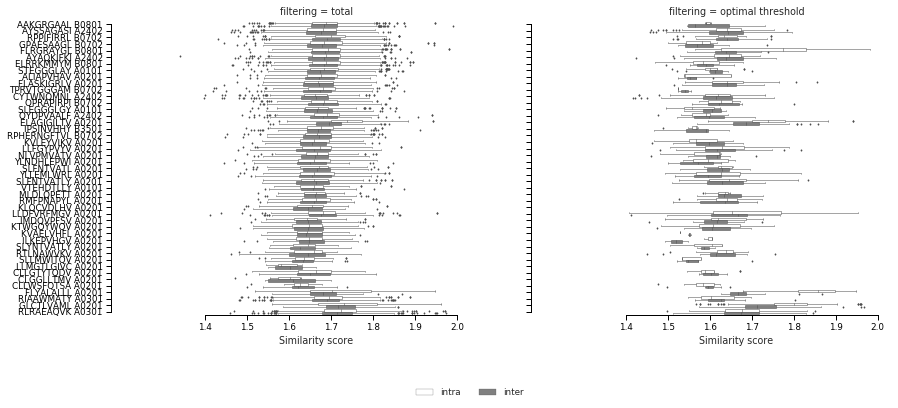

In [55]:
plt.figure(figsize=(9,30))
selected_filters = ['total','optimal threshold']
g = sns.catplot(y="peptide",
                x="score",
                hue="plateau", palette=['white','grey'],
                col="filtering",
                data=test_df[test_df.filtering.isin(selected_filters)],
                kind="box",sharey=True,
                legend=False, linewidth=0.5, fliersize=1, aspect=1.2)

for ax, flt in zip(g.axes[0], selected_filters):
    ct_per_pep = test_df[(test_df.rnd_sample==0) &
                         (test_df.plateau == 'intra') & 
                         (test_df.filtering == flt)].dropna().groupby(['peptide'],sort=False).size()
    for i,n in enumerate(ct_per_pep):
        ax.annotate(f'{n}', xy=(ax.get_xlim()[0],i), xytext=(-10, -1), textcoords='offset points', va='center', ha='right')

g.set_xlabels('Similarity score')
g.set_ylabels('') #Peptide HLA
#g.set_xticklabels(rotation=90, ha='center')
#plt.xticks(rotation=90, ha='center')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='center', frameon=False, ncol=2, bbox_transform=g.fig.transFigure)
#plt.legend(bbox_to_anchor=(1.2, 0.5), loc=6, frameon=False)
sns.despine(trim=True, offset={'left':55})
plt.subplots_adjust(wspace=0.40) #38

#plt.savefig(snakemake.output.score_per_pep, bbox_inches='tight')
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/sim.%s.png' %filter_set, bbox_inches='tight', dpi=300)
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/sim.%s.png' %filter_set, bbox_inches='tight', dpi=300)
plt.show()

In [41]:
rnd_sample = 1 #0
lst_scores = test_df[test_df.rnd_sample == rnd_sample].dropna().groupby(['filtering','plateau']).score.apply(list).to_frame().reset_index()
lst_lst_scores = lst_scores.groupby('filtering', sort=False).score.apply(list)
sign_test = lst_lst_scores.apply(lambda x: wilcoxon_test(x[-1],x[0])['test']) #wilcoxon_test()

In [42]:
lst_scores

,filtering,plateau,score
0,complete TCRs,inter,"[1.862826, 1.798759, 1.827219, 1.79719, 1.8151..."
1,complete TCRs,intra,"[1.838177, 1.808589, 1.828273, 1.856403, 1.787..."
2,icon,inter,"[1.505346, 1.513397, 1.5859, 1.629989, 1.64248..."
3,icon,intra,"[1.594448, 1.520699, 1.557808, 1.594448, 1.623..."
4,icon matching HLA,inter,"[1.5219930000000002, 1.500301, 1.679614, 1.677..."
5,icon matching HLA,intra,"[1.520699, 1.557808, 1.557808, 1.623358, 1.579..."
6,is cell,inter,"[1.868268, 1.781011, 1.777568, 1.820438, 1.796..."
7,is cell,intra,"[1.838177, 1.808589, 1.828273, 1.856403, 1.787..."
8,matching HLA,inter,"[1.746645, 1.679227, 1.642559, 1.711446, 1.692..."
9,matching HLA,intra,"[1.856403, 1.767636, 1.642559, 1.7033, 1.85640..."


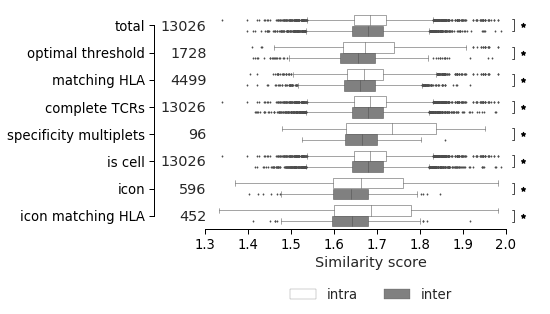

In [43]:
##########################
#   Plot pooled scores   #
##########################
#fig = plt.figure()
ax = sns.boxplot(y="filtering", x="score", order=labels, hue="plateau", palette=['white','grey'], data=test_df, linewidth=0.5, fliersize=1)
#add_significance_bar(plt_df, value='score', hue='plateau', labels='filtering')
ax.set_xlabel('Similarity score')
ax.set_ylabel('')

# Annotate counts
ct_per_flt = test_df[(test_df.rnd_sample==rnd_sample) &
                     (test_df.plateau == 'intra')].dropna().groupby(['filtering'],sort=False).size()
for i,n in enumerate(ct_per_flt):
    ax.annotate(f'{n}', xy=(ax.get_xlim()[0],i), xytext=(2, -1), textcoords='offset points', va='center', ha='right') #15 #,size=15

# Add significance bar
for i, c in enumerate(labels):
    if sign_test[c]:
        y = [i+0.22, i+0.22, i-0.22, i-0.22] #[0,0,1,1] #
        x0 = 2
        x1 = x0 * 1.007
        x2 = x0 * 1.010
        x3 = x0 * 1.020

    ax.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
    ax.plot(x3, np.mean(y), marker="*", c='0')
            
#for i, c in enumerate(labels):
#    ann = '*' if sign_test[c] else ''
#    ax.annotate(ann, xy=(2, i), #p.get_width()
#        xytext=(5, -1), textcoords='offset points', ha="left", va="center", size=12)

plt.legend(bbox_to_anchor=(0.5, -0.3), ncol=2, loc=10, frameon=False)
sns.despine(trim=True, offset={'left':50})
#plt.savefig('../experiments/exp10x/run1/plt/eval_filters/m.sim.pool.%s.png' %filter_set, bbox_inches='tight',dpi=300)
plt.show()

#plt_df.to_csv(snakemake.output.score_pooled[:-3] + 'csv', index=False)

In [46]:
test_df.groupby('filtering').size()

filtering
complete TCRs             26052
icon                       1192
icon matching HLA           904
is cell                   26052
matching HLA               8998
no negatives              20238
optimal threshold          3456
specificity multiplets      192
total                     26052
dtype: int64

In [48]:
test_df[test_df.filtering == 'specificity multiplets'].peptide.value_counts()

GLCTLVAML A0201     68
RLRAEAQVK A0301     40
FLYALALLL A0201     28
LLDFVRFMGV A0201    14
AYSSAGASI A2402     12
AAKGRGAAL B0801      6
RIAAWMATY A0301      6
GPAESAAGL B0702      4
FLRGRAYGL B0801      4
STEGGGLAY A0101      4
ELAGIGILTV A0201     4
QYDPVAALF A2402      2
Name: peptide, dtype: int64

In [99]:
auc_df.filtering.unique()

array(['total', 'optimal threshold', 'matching HLA', 'complete TCRs',
       'icon', 'icon matching HLA', 'specificity multiplets', 'is cell'],
      dtype=object)

# Plot AUC

In [100]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

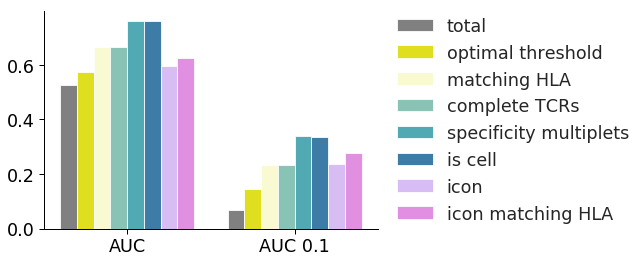

In [101]:
sns.barplot(data=auc_df, hue='filtering', hue_order=labels, palette=palette, y='value',x='variable', ci='sd') #
plt.legend(bbox_to_anchor=(1.01, 0.5), loc=6, frameon=False)
plt.ylabel('')
plt.xlabel('')
sns.despine()
#plt.xticks(rotation=90)
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/auc.bar.%s.png' %filter_set, bbox_inches='tight', dpi=300)
plt.savefig('../experiments/exp10x/run1/plt/eval_filters/m.auc.bar.%s.png' %filter_set, bbox_inches='tight', dpi=300)

In [72]:
test_df.groupby('filtering').AUC.mean()

filtering
complete TCRs             0.529838
icon                      0.597584
icon matching HLA         0.632127
is cell                   0.529820
matching HLA              0.555695
no negatives              0.533849
optimal threshold         0.576173
specificity multiplets    0.652344
total                     0.530370
Name: AUC, dtype: float64

In [73]:
test_df.groupby('filtering')['AUC 0.1'].mean()

filtering
complete TCRs             0.069965
icon                      0.246216
icon matching HLA         0.294659
is cell                   0.071741
matching HLA              0.109696
no negatives              0.077427
optimal threshold         0.173323
specificity multiplets    0.338542
total                     0.073309
Name: AUC 0.1, dtype: float64

In [74]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, flt in test_df.dropna().groupby('filtering'):
    fpr[i], tpr[i], _ = roc_curve(flt.label, flt.score, pos_label=2)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [75]:
roc_auc

{'complete TCRs': 0.5298384793912394,
 'icon': 0.5975842867438403,
 'icon matching HLA': 0.6321266348187016,
 'is cell': 0.5298204274110132,
 'matching HLA': 0.5556952198164509,
 'no negatives': 0.5338489613680217,
 'optimal threshold': 0.57617287969393,
 'specificity multiplets': 0.65234375,
 'total': 0.5303701700285548}

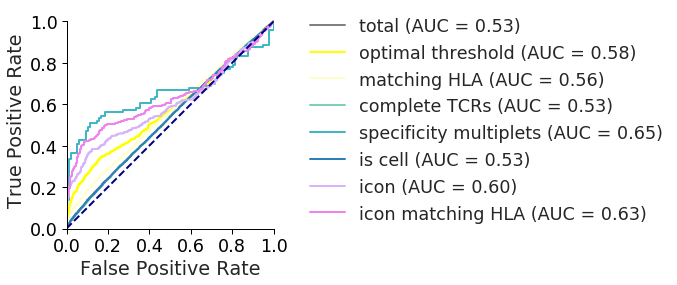

In [76]:
plt.figure()
lw = 2
for k,c in zip(labels,palette):
    plt.plot(fpr[k], tpr[k], c=c, lw=lw, label="%s (AUC = %0.2f)" %(k, roc_auc[k]))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.gca().set_aspect('equal', 'box')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("Receiver operating characteristic example")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc=6, frameon=False)
sns.despine(trim=True)
#plt.savefig('../experiments/exp13/run1_archive/plt/eval_filters/auc.roc.%s.png' %filter_set, bbox_inches='tight', dpi=300)
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/auc.roc.%s.png' %filter_set, bbox_inches='tight', dpi=300)
plt.show()